In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import imageio
import scipy.io as spio
import cv2
from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv
from scipy.stats import norm 
from scipy.stats import multivariate_normal
import time
import sys
from scipy.spatial import Delaunay
import matplotlib.image as mpimg
import dlib

%matplotlib inline
plt.style.use('default')

Step 0: Read images

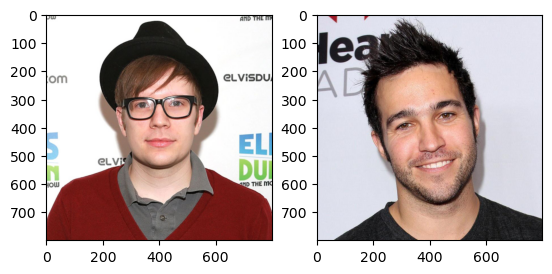

In [40]:
# the follow images are members of my favourite band Fall Out Boy
image1 = plt.imread("Orifaces\\patrick.jpg")
image2 = plt.imread("Orifaces\\pete.jpg")
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.imshow(image2)

Step 1: Find some corresponding face landmarks between start and end images and display them

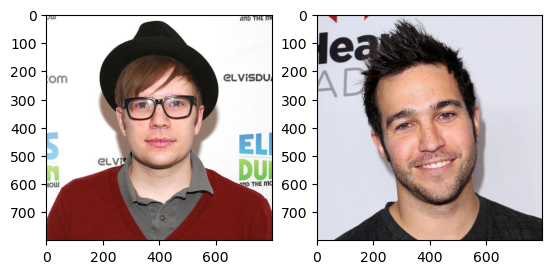

In [41]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def get_landmarks(image):
    landmarks = []
    detections = detector(image, 1)
    for k, d in enumerate(detections):
        shape = predictor(image, d)
        for i in range(0, 68):
            x = shape.part(i).x
            y = shape.part(i).y
            landmarks.append((x, y))
            # draw landmarks point on image
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
    return landmarks, image

landmarks1, image1_with_landmarks = get_landmarks(image1)
landmarks2, image2_with_landmarks = get_landmarks(image2)

plt.subplot(1, 2, 1)
plt.imshow(image1_with_landmarks)
plt.subplot(1, 2, 2)
plt.imshow(image2_with_landmarks)

Step 2:  Create a triangulation and visualise it.

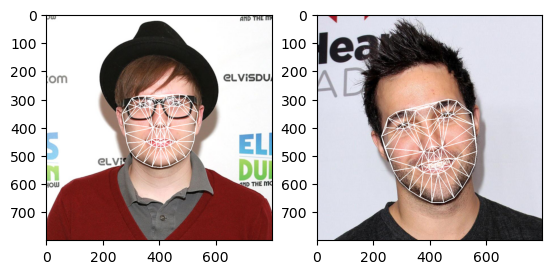

In [83]:
def draw_delaunay(img, points, triangles, color=(255, 255, 255)):
    # draw the triangles using given triangle indices
    for tri in triangles:
        pt1 = (int(points[tri[0]][0]), int(points[tri[0]][1]))
        pt2 = (int(points[tri[1]][0]), int(points[tri[1]][1]))
        pt3 = (int(points[tri[2]][0]), int(points[tri[2]][1]))

        cv2.line(img, pt1, pt2, color, 1, cv2.LINE_AA, 0)
        cv2.line(img, pt2, pt3, color, 1, cv2.LINE_AA, 0)
        cv2.line(img, pt3, pt1, color, 1, cv2.LINE_AA, 0)

# Create Delaunay triangulation for the first image
delaunay_triangles1 = Delaunay(landmarks1)

draw_delaunay(image1, landmarks1, delaunay_triangles1.simplices)
draw_delaunay(image2, landmarks2, delaunay_triangles1.simplices)

plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.show()

delaunay_triangles1 = delaunay_triangles1.simplices

Step3: Create the intermediate image coordinates

In [86]:
def interpolate_points(p1, p2, steps=50):
    # Create an array to hold the interpolated points
    interpolated_points = np.zeros((steps, p1.shape[0], 3, 2), dtype=np.float32)
    
    for t in range(p1.shape[0]):
        for v in range(3):  # Three vertices per triangle
            # Linear interpolation for x coordinate
            interpolated_points[:, t, v, 0] = np.linspace(p1[t, v, 0], p2[t, v, 0], num=steps)
            # Linear interpolation for y coordinate
            interpolated_points[:, t, v, 1] = np.linspace(p1[t, v, 1], p2[t, v, 1], num=steps)
            
    return interpolated_points

# Get the actual triangle vertices for each image
triangles1 = np.array([[landmarks1[vertex] for vertex in triangle] for triangle in delaunay_triangles1])
triangles2 = np.array([[landmarks2[vertex] for vertex in triangle] for triangle in delaunay_triangles1])

# Perform interpolation
interpolated_triangles = interpolate_points(triangles1, triangles2)
print(interpolated_triangles)

[[[[320.      327.     ]
   [275.      387.     ]
   [269.      352.     ]]

  [[483.      321.     ]
   [513.      308.     ]
   [537.      348.     ]]

  [[513.      308.     ]
   [483.      321.     ]
   [497.      289.     ]]

  ...

  [[420.      450.     ]
   [419.      438.     ]
   [439.      444.     ]]

  [[406.      452.     ]
   [420.      450.     ]
   [420.      453.     ]]

  [[420.      450.     ]
   [406.      452.     ]
   [406.      443.     ]]]


 [[[319.36734 328.57144]
   [274.26532 388.7755 ]
   [268.16327 353.63266]]

  [[482.93878 321.69388]
   [513.0204  308.44897]
   [537.2041  348.02042]]

  [[513.0204  308.44897]
   [482.93878 321.69388]
   [496.9592  289.36734]]

  ...

  [[420.40817 451.5102 ]
   [419.36734 439.57144]
   [439.5102  445.34692]]

  [[406.26532 453.59183]
   [420.40817 451.5102 ]
   [420.4898  454.79593]]

  [[420.40817 451.5102 ]
   [406.26532 453.59183]
   [406.20407 444.61224]]]


 [[[318.73468 330.14285]
   [273.5306  390.55103]
   [267.